# Lab1: back-propagation

> student id: 313551097
>
> student name: 鄭淮薰

## Experiment setups

### Data Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math


def generate_linear(n=100):
    import numpy as np
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append (0)
        else:
            labels.append (1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    import numpy as np
    inputs = []
    labels = []
    
    for i in range (11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if 0.1*i == 0.5:
            continue
        
        inputs.append([0.1*i, 1-0.1*i])
        labels.append (1)
    return np.array(inputs), np.array(labels).reshape (21, 1)

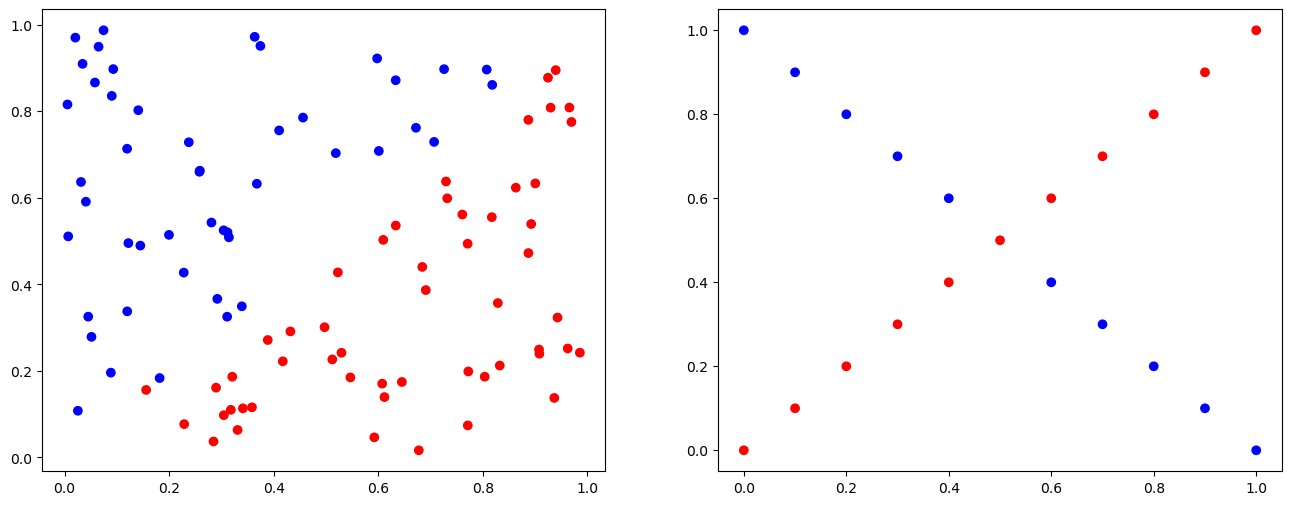

In [2]:
np.random.seed(42)
ax, fig = plt.subplots(1, 2, figsize=(16, 6))

# linear dataset
x,y = generate_linear(n=100)
linear_data = [x,y]
colors = ['red' if label == 0 else 'blue' for label in y[:,0]]
fig[0].scatter(x[:,0], x[:,1], c=colors)

# XOR dataset
x,y = generate_XOR_easy()
xor_data = [x,y]
colors = ['red' if label == 0 else 'blue' for label in y[:,0]]
fig[1].scatter(x[:,0], x[:,1], c=colors)

### Activation Functions

In [3]:
class Activation:
    # Sigmoid function
    @staticmethod
    def sigmoid(x, deriv=False):
        if deriv is True:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    # relu function
    @staticmethod
    def relu(x, deriv=False):
        if deriv is True:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)

    # tanh function
    @staticmethod
    def tanh(x, deriv=False):
        if deriv is True:
            return 1.0 - x**2
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    # without activation function
    @staticmethod
    def without_activation(x, deriv=False):
        if deriv is True:
            return 1
        return x

### Visualization Functions

In [4]:
def show_result(x, y, predicts, labels=None):
    nrows, ncols = math.ceil((len(predicts)+1)/2.0), 2
    plt.rc('figure', figsize=(16, 6 + nrows*2 - 2))
    plt.subplot(nrows,ncols,1)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    for k in range(2, len(predicts)+2):
        plt.subplot(nrows,ncols,k)
        if labels:
            plt.title(f'Predict result ({labels[k-2]})', fontsize=18)
        else:
            plt.title(f'Predict result', fontsize=18)
        for i in range(x.shape[0]):
            if predicts[k-2][i] == 0:
                plt.plot(x[i][0], x[i][1], 'ro')
            else:
                plt.plot(x[i][0], x[i][1], 'bo')

def learning_curve(histories, labels=['Training Loss']):
    plt.figure(figsize=(16, 6))
    for history, label in zip(histories, labels):
        train_loss_values = [h['loss'] for h in history]
        epochs = [h['epoch'] for h in history]
        plt.plot(epochs, train_loss_values, label=label)
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

### Neural network

In [5]:
class AdaGrad:
    def __init__(self, weights, biases, epsilon=1e-8):
        self.epsilon = epsilon
        self.dw_squared = [np.zeros_like(p) for p in weights]
        self.db_squared = [np.zeros_like(p) for p in biases]

    def update(self, weights, biases, grads, lr=0.001):
        dw, db = grads
        for i in range(1, len(weights)):
            self.dw_squared[i] += dw[i]**2
            self.db_squared[i] += db[i]**2

            weights[i] -= lr * dw[i] / (np.sqrt(self.dw_squared[i]) + self.epsilon)
            biases[i] -= lr * db[i] / (np.sqrt(self.db_squared[i]) + self.epsilon)
        return weights, biases

In [6]:
class NeuralNetwork:
    def __init__(self, input_dim, output_dim, batch_size, n_units=[4,4], n_hidden_layers=2, activation=Activation.sigmoid, learning_rate = 0.001, optimizer=None):
        self.input_dim = input_dim
        self.output_size = output_dim
        self.batch_size = batch_size
        self.n_units = n_units
        self.n_hidden_layers = n_hidden_layers
        self.activation = activation
        self.learning_rate = learning_rate
        self.optimizer = None
        self.history = []

        # Initialize weights and biases 
        # self.w1 = np.random.rand(self.input_size, self.n_units[0])
        # self.w2 = np.random.rand(self.n_units[0], self.n_units[1])
        # self.w3 = np.random.rand(self.n_units[1], self.output_size)
        # self.b1 = 0.001
        # self.b2 = 0.001
        # self.b3 = 0.001
        self.weights = [None,np.random.rand(self.input_dim, self.n_units[0]),
                        np.random.rand(self.n_units[0], self.n_units[1]),
                        np.random.rand(self.n_units[1], self.output_size)]
        # self.biases = [0.001] * (len(self.weights)+1)
        self.biases = [None,np.random.rand(self.batch_size, self.n_units[0]),
                        np.random.rand(self.batch_size, self.n_units[1]),
                        np.random.rand(self.batch_size, self.output_size)]

        if optimizer == "AdaGrad":
            self.optimizer = AdaGrad(self.weights, self.biases)

    def forward(self, x):
        self.hidden_layer1_output = self.activation(np.dot(x, self.weights[1]) + self.biases[1])
        self.hidden_layer2_output = self.activation(np.dot(self.hidden_layer1_output, self.weights[2]) + self.biases[2])
        self.output = self.activation(np.dot(self.hidden_layer2_output, self.weights[3])+self.biases[3])
        return self.output
    
    def backword(self, x, y_true):
        # Output layer
        error = self.output - y_true
        delta3 = error * self.activation(self.output, deriv=True)
        # Hidden layer
        delta2 = np.dot(delta3, self.weights[3].T) * self.activation(self.hidden_layer2_output, deriv=True)        
        delta1 = np.dot(delta2, self.weights[2].T) * self.activation(self.hidden_layer1_output, deriv=True)
        
        dw3 = np.dot(self.hidden_layer2_output.T, delta3)
        db3 = delta3
        dw2 = np.dot(self.hidden_layer1_output.T, delta2)
        db2 = delta2
        dw1 = np.dot(x.T, delta1)
        db1 = delta1

        grads = [ [None,dw1,dw2,dw3],[None,db1,db2,db3]]
        return grads
        
    def update(self, grads):
        if self.optimizer == None:
            dw, db = grads
            for i in range(1,len(self.weights)):
                self.weights[i] -= self.learning_rate * dw[i]
                self.biases[i] -= self.learning_rate * db[i]
            # self.w3 -= self.learning_rate * dw[2]
            # self.b3 -= self.learning_rate * db[2]
            # self.w2 -= self.learning_rate * dw[1]
            # self.b2 -= self.learning_rate * db[1]
            # self.w1 -= self.learning_rate * dw[0]
            # self.b1 -= self.learning_rate * db[0]
        else:
            self.weights, self.biases = self.optimizer.update(self.weights, self.biases, grads)

    def train(self, data, gt, epochs=100001):
        for epoch in range(epochs):
            self.forward(data)
            grads = self.backword(data, gt)
            self.update(grads)
            train_loss = NeuralNetwork.loss(gt, self.output)
            
            # Show Info
            if(epoch % 5000 == 0):
                print(f"epoch {epoch} loss : {train_loss}")
            
            # History
            if(epoch % 100 == 0):
                self.history.append({
                    "epoch": epoch,
                    "loss": train_loss
                })

        return self.output, NeuralNetwork.loss(self.output, gt), self.history
    
    def predict_prob(self, x):
        return self.forward(x)
    
    @staticmethod
    def loss(gt, predict):
        return np.mean((gt - predict)**2)

## Results

### Linear Data

--------------- Training ----------------
epoch 0 loss : 0.42078797089687897
epoch 5000 loss : 0.13273937886003845
epoch 10000 loss : 0.06921676944511378
epoch 15000 loss : 0.029807791029369278
epoch 20000 loss : 0.011835533624889762
epoch 25000 loss : 0.005728006591161405
epoch 30000 loss : 0.003358240621789453
epoch 35000 loss : 0.0022348450760553383
epoch 40000 loss : 0.0016165871737354772
epoch 45000 loss : 0.0012384541171843956
epoch 50000 loss : 0.0009888084670594559
epoch 55000 loss : 0.0008142846746606354
epoch 60000 loss : 0.0006867723853211367
epoch 65000 loss : 0.0005902968156675526
epoch 70000 loss : 0.000515212412790521
epoch 75000 loss : 0.0004554005690944815
epoch 80000 loss : 0.0004068180399026545
epoch 85000 loss : 0.0003666996054596026
epoch 90000 loss : 0.00033309795625469443
epoch 95000 loss : 0.0003046067840579674
epoch 100000 loss : 0.00028018798952019245
--------------- Testing -----------------
Iter0 |	Ground truth: 1 |	 prediction: 0.9939461169329532 |
Iter1 |	

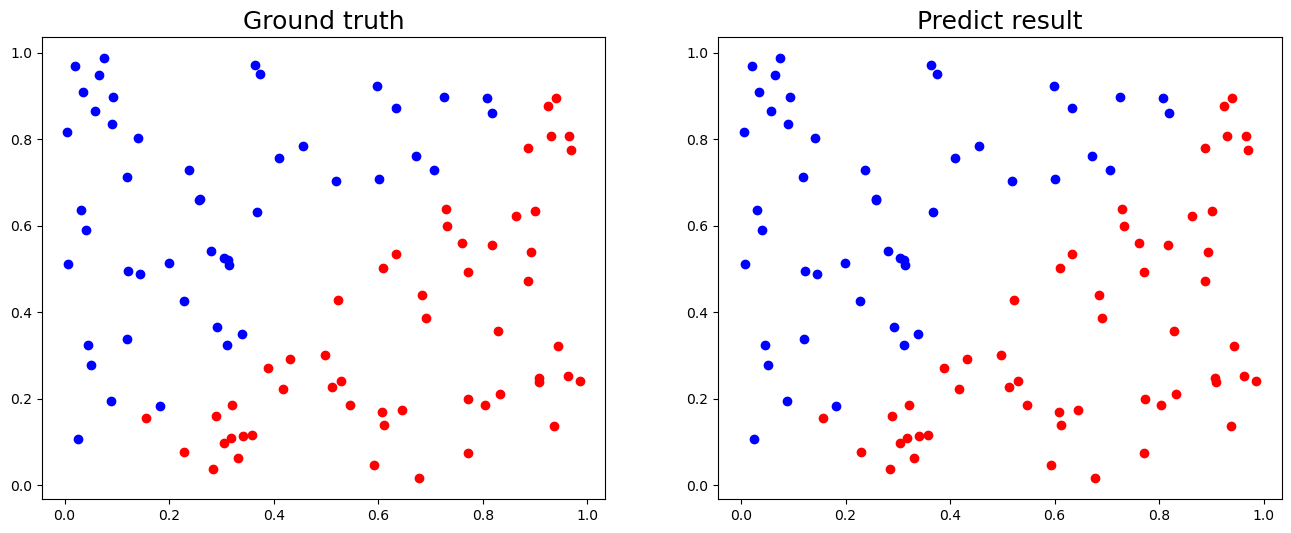

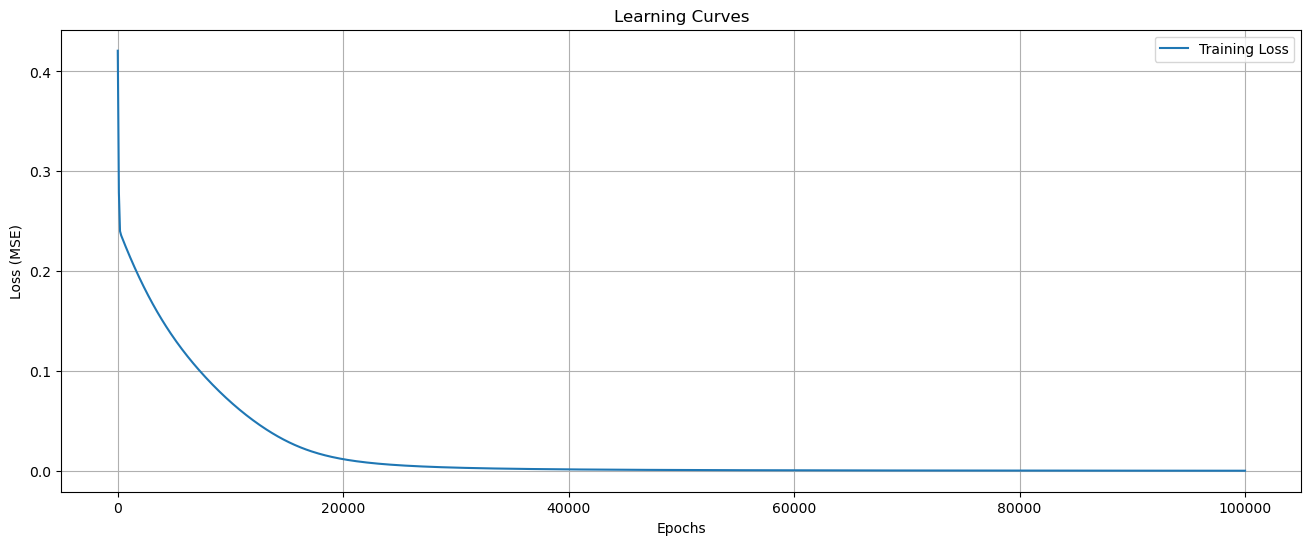

In [7]:
x,y = linear_data

# Training
model = NeuralNetwork(x.shape[1],1,x.shape[0])

print("--------------- Training ----------------")
train_out, train_model_mse, history = model.train(x,y)

# Testing
print("--------------- Testing -----------------")
y_pred_prob = model.predict_prob(x)
for i in range(x.shape[0]):
    print(f"Iter{i} |\tGround truth: {y[i,0]} |\t prediction: {y_pred_prob[i,0]} |")
train_loss = NeuralNetwork.loss(y, y_pred_prob)

predict = np.where(y_pred_prob > 0.5, 1, 0)
print(f"loss: {train_loss} accuracy: {sum(1 for i, j in zip(y, predict) if i == j) / len(y)}")

show_result(x, y, [predict])
learning_curve([history])

### XOR Data

--------------- Training ----------------
epoch 0 loss : 0.47698836788206106
epoch 5000 loss : 0.15041161904243866
epoch 10000 loss : 0.09045491145076102
epoch 15000 loss : 0.06074672404057211
epoch 20000 loss : 0.04437606612753396
epoch 25000 loss : 0.03439272353809201
epoch 30000 loss : 0.027804527193732678
epoch 35000 loss : 0.02318822497162163
epoch 40000 loss : 0.019800925504375608
epoch 45000 loss : 0.017223746755416963
epoch 50000 loss : 0.01520516252530007
epoch 55000 loss : 0.013586153475592222
epoch 60000 loss : 0.012261803585001032
epoch 65000 loss : 0.011160372934443321
epoch 70000 loss : 0.010231296569882616
epoch 75000 loss : 0.009437995567653314
epoch 80000 loss : 0.008753405983368576
epoch 85000 loss : 0.00815710599396309
epoch 90000 loss : 0.007633416501355915
epoch 95000 loss : 0.007170113322734333
epoch 100000 loss : 0.006757534299694122
--------------- Testing -----------------
Iter0 |	Ground truth: 0 |	 prediction: 0.0818790680280117 |
Iter1 |	Ground truth: 1 |	 pr

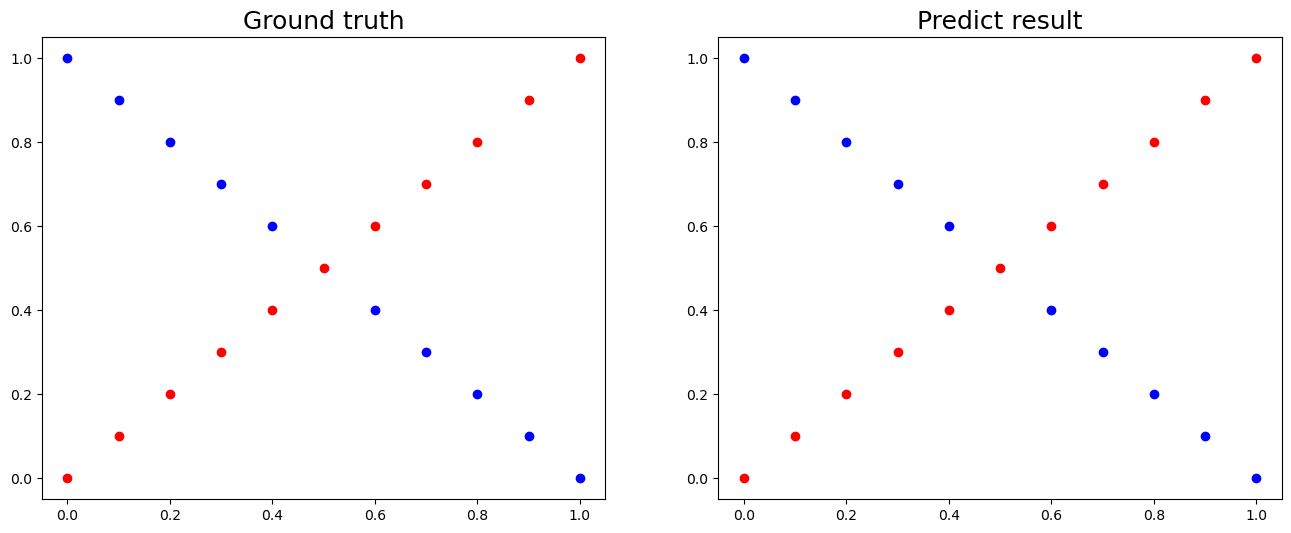

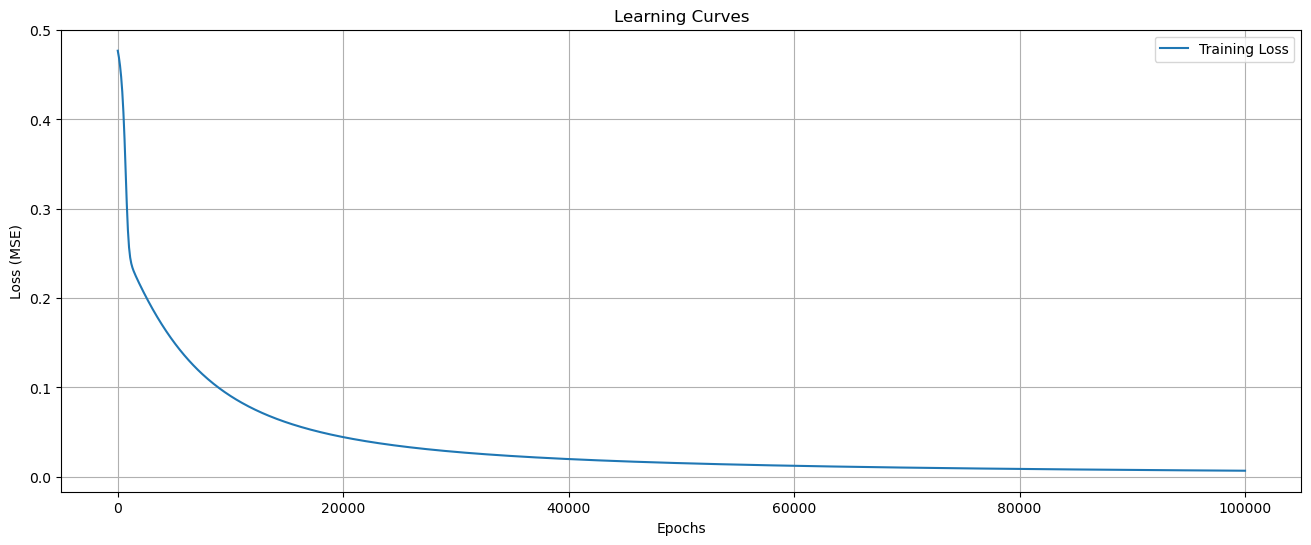

In [8]:
x,y = xor_data

# Training
model = NeuralNetwork(x.shape[1],1,x.shape[0])

print("--------------- Training ----------------")
train_out, train_model_mse, history = model.train(x,y)

# Testing
print("--------------- Testing -----------------")
y_pred_prob = model.predict_prob(x)
for i in range(x.shape[0]):
    print(f"Iter{i} |\tGround truth: {y[i,0]} |\t prediction: {y_pred_prob[i,0]} |")
train_loss = NeuralNetwork.loss(y, y_pred_prob)

predict = np.where(y_pred_prob > 0.5, 1, 0)
print(f"loss: {train_loss} accuracy: {sum(1 for i, j in zip(y, predict) if i == j) / len(y)}")
show_result(x, y, [predict])
learning_curve([history])

## Discussion

### A. Different learning rates

#### Linear Data

--------------- Training (lr = 0.1) ----------------
epoch 0 loss : 0.45599896928312283
epoch 5000 loss : 4.320634044442202e-05
epoch 10000 loss : 1.8251989314119764e-05
epoch 15000 loss : 1.1267385948932316e-05
epoch 20000 loss : 8.056710181518113e-06
epoch 25000 loss : 6.230803462397393e-06
epoch 30000 loss : 5.059585084258623e-06
epoch 35000 loss : 4.247529530749517e-06
epoch 40000 loss : 3.6529451641779046e-06
epoch 45000 loss : 3.1996576681466246e-06
epoch 50000 loss : 2.8431706557278432e-06
epoch 55000 loss : 2.555798255444631e-06
epoch 60000 loss : 2.3194362716476953e-06
epoch 65000 loss : 2.121760581490957e-06
epoch 70000 loss : 1.9540986006982208e-06
epoch 75000 loss : 1.8101747694292142e-06
epoch 80000 loss : 1.6853388168267594e-06
epoch 85000 loss : 1.5760734583698257e-06
epoch 90000 loss : 1.4796703948832626e-06
epoch 95000 loss : 1.3940112169997821e-06
epoch 100000 loss : 1.3174156834334252e-06
--------------- Testing (lr = 0.1) -----------------
loss: 1.317401176225008e-0

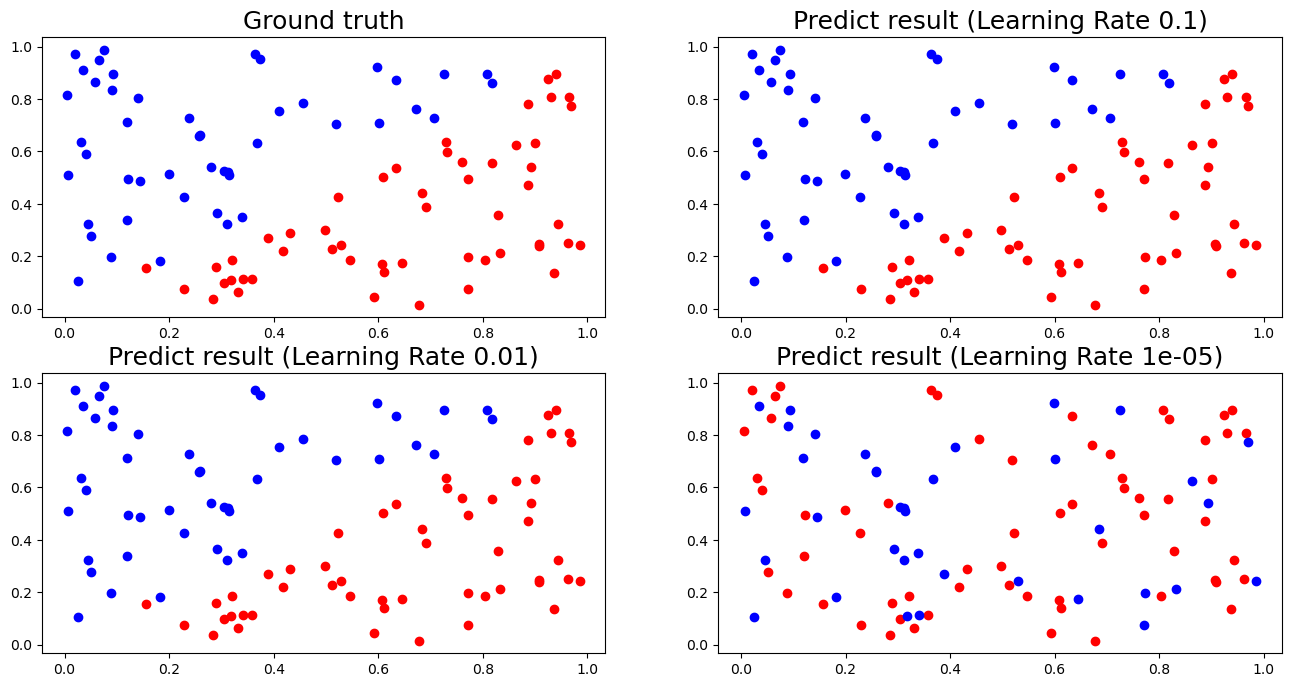

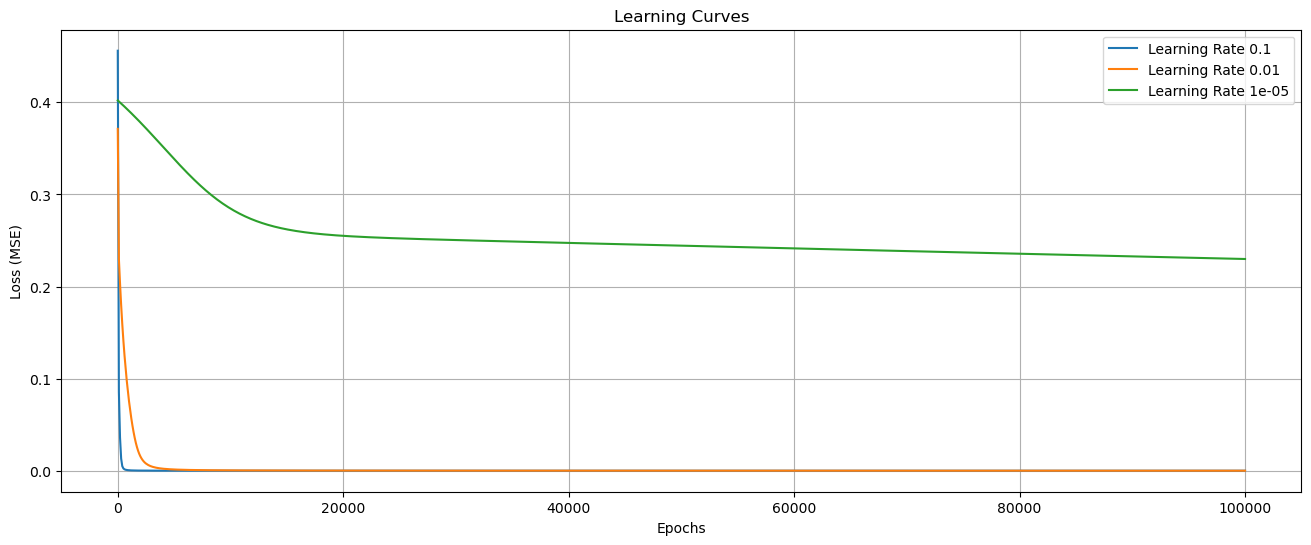

In [9]:
x,y = linear_data
models = []
histories = []
predicts = []
labels = []

for i, lr in enumerate([0.1, 0.01, 0.00001]):
    # Training
    model = NeuralNetwork(x.shape[1],1,x.shape[0],learning_rate=lr)
    models.append(model)
    print(f"--------------- Training (lr = {lr}) ----------------")
    train_out, train_model_mse, history = model.train(x,y)  
    histories.append(history)
    labels.append(f"Learning Rate {lr}")  

    # Testing
    print(f"--------------- Testing (lr = {lr}) -----------------")
    y_pred_prob = model.predict_prob(x)
    train_loss = NeuralNetwork.loss(y, y_pred_prob)
    predict = np.where(y_pred_prob > 0.5, 1, 0)
    print(f"loss: {train_loss} accuracy: {sum(1 for i, j in zip(y, predict) if i == j) / len(y)}\n")
    predicts.append(predict)
    
show_result(x, y, predicts, labels)
learning_curve(histories, labels)

#### XOR Data

--------------- Training (lr = 0.1) ----------------
epoch 0 loss : 0.3804829534648606
epoch 5000 loss : 0.0007448047195999679
epoch 10000 loss : 0.00028983087843161167
epoch 15000 loss : 0.00016753300258980195
epoch 20000 loss : 0.00011407856624960791
epoch 25000 loss : 8.4951564398418e-05
epoch 30000 loss : 6.69206732603767e-05
epoch 35000 loss : 5.4787470783219675e-05
epoch 40000 loss : 4.6127846703637244e-05
epoch 45000 loss : 3.967091698599798e-05
epoch 50000 loss : 3.469089630533658e-05
epoch 55000 loss : 3.074530402240525e-05
epoch 60000 loss : 2.755008523797844e-05
epoch 65000 loss : 2.4915095589413197e-05
epoch 70000 loss : 2.270857047302577e-05
epoch 75000 loss : 2.0836502659031564e-05
epoch 80000 loss : 1.9230135849979558e-05
epoch 85000 loss : 1.7838092117611263e-05
epoch 90000 loss : 1.6621254806293085e-05
epoch 95000 loss : 1.55493484146926e-05
epoch 100000 loss : 1.4598596042416046e-05
--------------- Testing (lr = 0.1) -----------------
loss: 1.4598416680140832e-05 accu

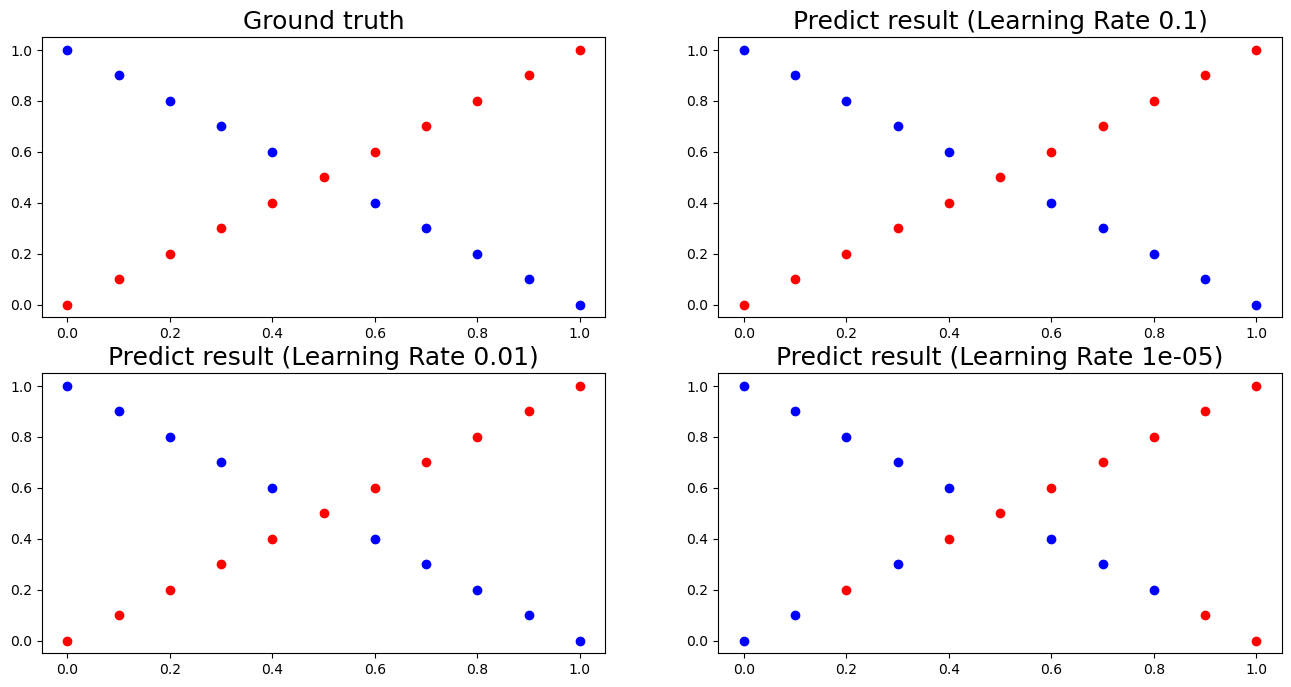

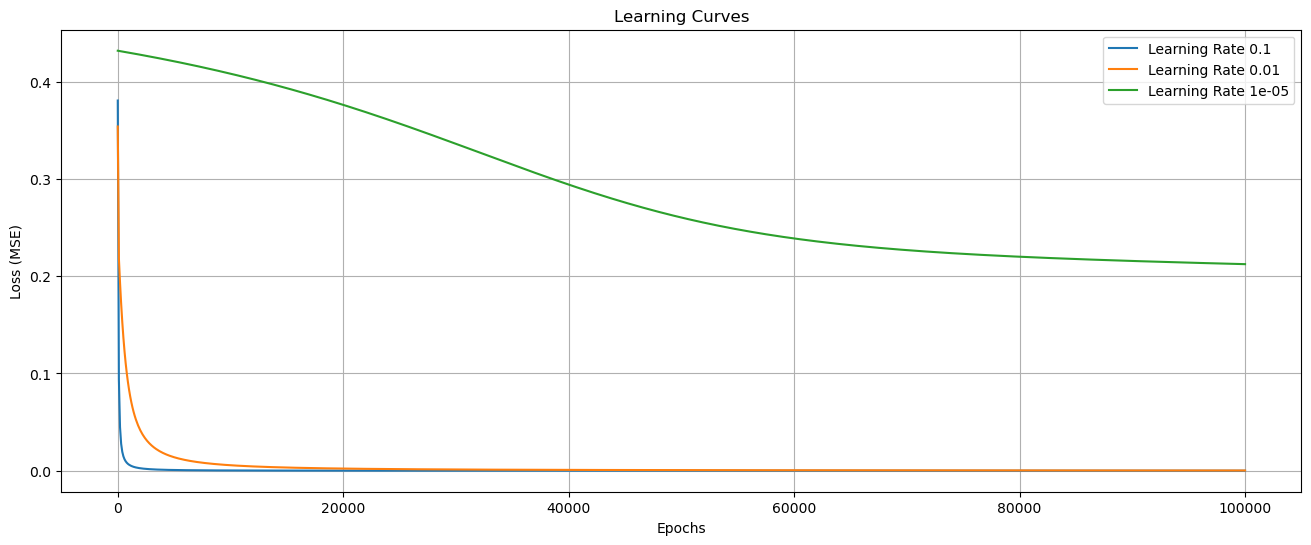

In [10]:
x,y = xor_data
models = []
histories = []
predicts = []
labels = []

for i, lr in enumerate([0.1, 0.01, 0.00001]):
    # Training
    model = NeuralNetwork(x.shape[1],1,x.shape[0],learning_rate=lr)
    models.append(model)
    print(f"--------------- Training (lr = {lr}) ----------------")
    train_out, train_model_mse, history = model.train(x,y)  
    histories.append(history)
    labels.append(f"Learning Rate {lr}")  

    # Testing
    print(f"--------------- Testing (lr = {lr}) -----------------")
    y_pred_prob = model.predict_prob(x)
    train_loss = NeuralNetwork.loss(y, y_pred_prob)
    predict = np.where(y_pred_prob > 0.5, 1, 0)
    print(f"loss: {train_loss} accuracy: {sum(1 for i, j in zip(y, predict) if i == j) / len(y)}\n")
    predicts.append(predict)
    
show_result(x, y, predicts, labels)
learning_curve(histories, labels)

### B. Different numbers of hidden units

#### Linear Data

--------------- Training (units = [1, 1]) ----------------
epoch 0 loss : 0.2913017360886822
epoch 5000 loss : 0.1380194924451806
epoch 10000 loss : 0.08225983810929943
epoch 15000 loss : 0.054276830446381104
epoch 20000 loss : 0.03832361479625584
epoch 25000 loss : 0.028149317275800355
epoch 30000 loss : 0.021227541366792068
epoch 35000 loss : 0.016386038615738695
epoch 40000 loss : 0.012944433215258398
epoch 45000 loss : 0.01046729382375141
epoch 50000 loss : 0.008662044566010357
epoch 55000 loss : 0.007324747312349932
epoch 60000 loss : 0.006313683534364748
epoch 65000 loss : 0.005532196942651961
epoch 70000 loss : 0.004914976952385122
epoch 75000 loss : 0.00441769822397503
epoch 80000 loss : 0.004009859596323604
epoch 85000 loss : 0.0036700816813601085
epoch 90000 loss : 0.0033830766431555198
epoch 95000 loss : 0.003137694338473655
epoch 100000 loss : 0.0029256486364144544
--------------- Testing (units = [1, 1]) -----------------
loss: 0.002925609116475216 accuracy: 1.0

---------

epoch 25000 loss : 0.019117411391897286
epoch 30000 loss : 0.012131148747889398
epoch 35000 loss : 0.008048584152623904
epoch 40000 loss : 0.005620274355030787
epoch 45000 loss : 0.0041189164697665315
epoch 50000 loss : 0.003146708617744891
epoch 55000 loss : 0.0024879850572282936
epoch 60000 loss : 0.0020231490016115548
epoch 65000 loss : 0.001683395670288588
epoch 70000 loss : 0.0014275022766895992
epoch 75000 loss : 0.001229779092254019
epoch 80000 loss : 0.0010736262477189188
epoch 85000 loss : 0.0009479631531298957
epoch 90000 loss : 0.0008451765905453667
epoch 95000 loss : 0.0007598999442209117
epoch 100000 loss : 0.0006882632199806437
--------------- Testing (units = [3, 2]) -----------------
loss: 0.0006882500534448362 accuracy: 1.0

--------------- Training (units = [5, 5]) ----------------
epoch 0 loss : 0.463433616418641
epoch 5000 loss : 0.138329898267319
epoch 10000 loss : 0.08387266732455778
epoch 15000 loss : 0.055877387681213087
epoch 20000 loss : 0.03912552275722805
ep

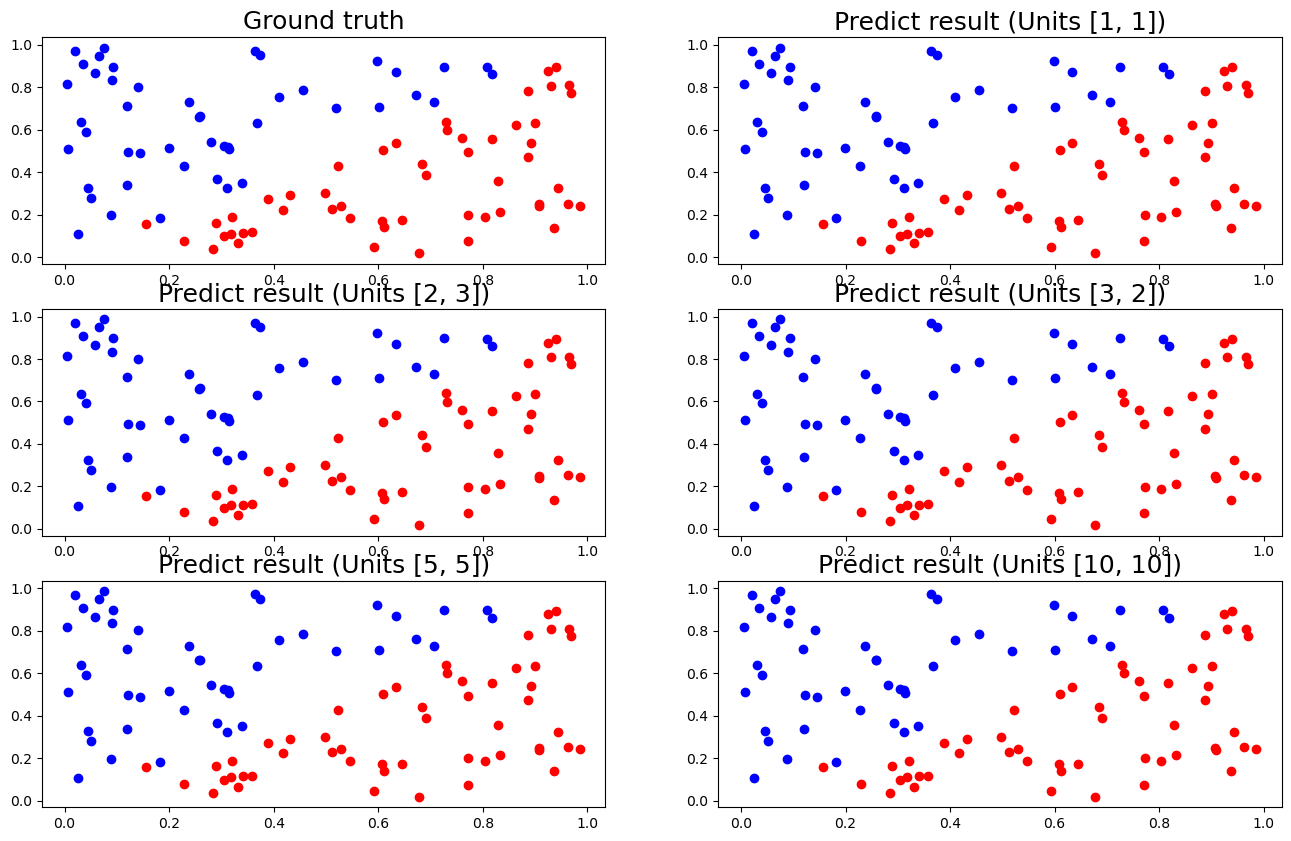

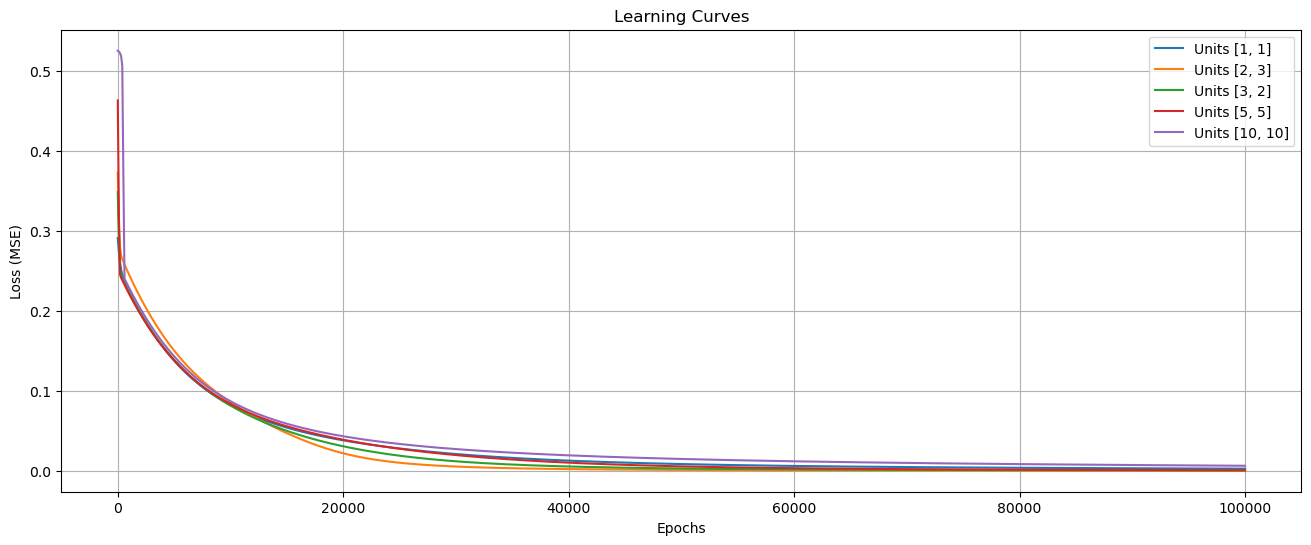

In [11]:
x,y = linear_data
models = []
histories = []
predicts = []
labels = []

for i, units in enumerate([[1,1], [2,3], [3,2], [5,5], [10,10]]):
    # Training
    model = NeuralNetwork(x.shape[1],1,x.shape[0],n_units=units)
    models.append(model)
    print(f"--------------- Training (units = {units}) ----------------")
    train_out, train_model_mse, history = model.train(x,y)  
    histories.append(history)
    labels.append(f"Units {units}")  

    # Testing
    print(f"--------------- Testing (units = {units}) -----------------")
    y_pred_prob = model.predict_prob(x)
    train_loss = NeuralNetwork.loss(y, y_pred_prob)
    predict = np.where(y_pred_prob > 0.5, 1, 0)
    print(f"loss: {train_loss} accuracy: {sum(1 for i, j in zip(y, predict) if i == j) / len(y)}\n")
    predicts.append(predict)
    
show_result(x, y, predicts, labels)
learning_curve(histories, labels)

#### XOR Data

--------------- Training (units = [1, 1]) ----------------
epoch 0 loss : 0.29661281586094845
epoch 5000 loss : 0.14191452046549444
epoch 10000 loss : 0.08597904609259586
epoch 15000 loss : 0.05816152181325011
epoch 20000 loss : 0.042707744394005764
epoch 25000 loss : 0.03321624796488322
epoch 30000 loss : 0.026917845089183653
epoch 35000 loss : 0.0224858311947506
epoch 40000 loss : 0.019223070976554228
epoch 45000 loss : 0.016734250781139604
epoch 50000 loss : 0.014780877187072505
epoch 55000 loss : 0.013211579708052286
epoch 60000 loss : 0.011926161570785505
epoch 65000 loss : 0.01085592042689681
epoch 70000 loss : 0.00995231839228368
epoch 75000 loss : 0.00918017202760411
epoch 80000 loss : 0.008513404396798636
epoch 85000 loss : 0.007932308494340932
epoch 90000 loss : 0.007421733829948164
epoch 95000 loss : 0.006969854435417901
epoch 100000 loss : 0.00656731314147228
--------------- Testing (units = [1, 1]) -----------------
loss: 0.006567237041995181 accuracy: 1.0

---------------

epoch 35000 loss : 0.023066036173545724
epoch 40000 loss : 0.0196930455794959
epoch 45000 loss : 0.017125224107937393
epoch 50000 loss : 0.015112988638732642
epoch 55000 loss : 0.013498402137450774
epoch 60000 loss : 0.012177186113554997
epoch 65000 loss : 0.011077994439707722
epoch 70000 loss : 0.010150515474083653
epoch 75000 loss : 0.00935833904384383
epoch 80000 loss : 0.00867451709932234
epoch 85000 loss : 0.008078709568923322
epoch 90000 loss : 0.007555296403730484
epoch 95000 loss : 0.007092096984175421
epoch 100000 loss : 0.006679481908812653
--------------- Testing (units = [5, 5]) -----------------
loss: 0.006679403904258315 accuracy: 1.0

--------------- Training (units = [10, 10]) ----------------
epoch 0 loss : 0.5208087521516216
epoch 5000 loss : 0.2338729653563362
epoch 10000 loss : 0.13075565620577617
epoch 15000 loss : 0.08117524496329415
epoch 20000 loss : 0.055945612514333484
epoch 25000 loss : 0.04161152168602284
epoch 30000 loss : 0.03265806483719935
epoch 35000 lo

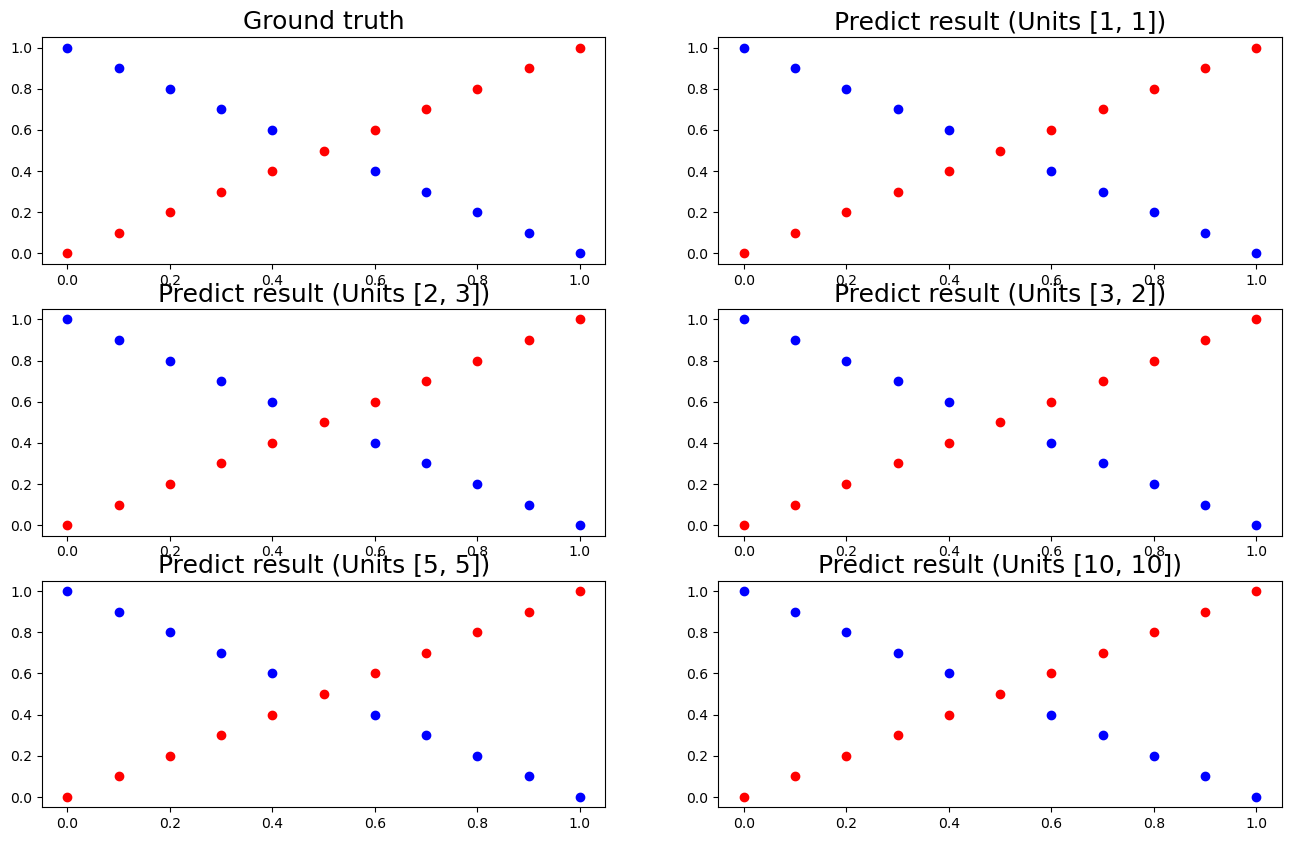

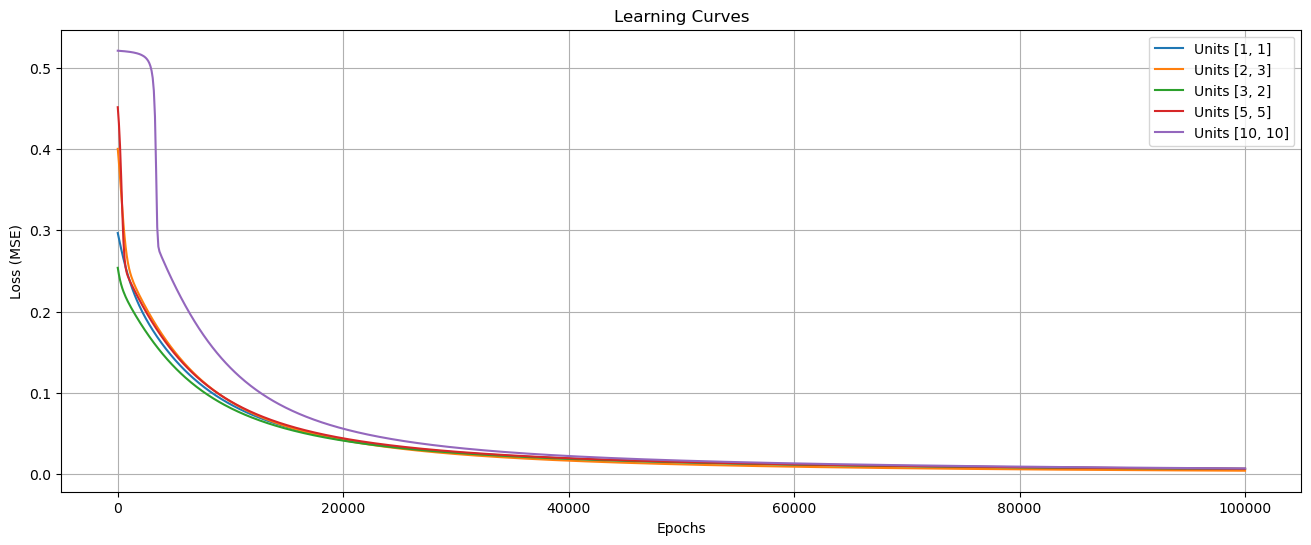

In [12]:
x,y = xor_data
models = []
histories = []
predicts = []
labels = []

for i, units in enumerate([[1,1], [2,3], [3,2], [5,5], [10,10]]):
    # Training
    model = NeuralNetwork(x.shape[1],1,x.shape[0],n_units=units)
    models.append(model)
    print(f"--------------- Training (units = {units}) ----------------")
    train_out, train_model_mse, history = model.train(x,y)  
    histories.append(history)
    labels.append(f"Units {units}")  

    # Testing
    print(f"--------------- Testing (units = {units}) -----------------")
    y_pred_prob = model.predict_prob(x)
    train_loss = NeuralNetwork.loss(y, y_pred_prob)
    predict = np.where(y_pred_prob > 0.5, 1, 0)
    print(f"loss: {train_loss} accuracy: {sum(1 for i, j in zip(y, predict) if i == j) / len(y)}\n")
    predicts.append(predict)
    
show_result(x, y, predicts, labels)
learning_curve(histories, labels)

### C. Without activation functions

#### Linear Data

--------------- Training (function = sigmoid) ----------------
epoch 0 loss : 0.37100642832424696
epoch 5000 loss : 0.1466105965089553
epoch 10000 loss : 0.08828685401483609
epoch 15000 loss : 0.05916823643616611
epoch 20000 loss : 0.04286672031089433
epoch 25000 loss : 0.032664902543240226
epoch 30000 loss : 0.025616385895897466
epoch 35000 loss : 0.020273872367689162
epoch 40000 loss : 0.015907180752479738
epoch 45000 loss : 0.012250333316123463
epoch 50000 loss : 0.00927481176282368
epoch 55000 loss : 0.00696463258355443
epoch 60000 loss : 0.005246498838253376
epoch 65000 loss : 0.004004051961470079
epoch 70000 loss : 0.0031140252222195664
epoch 75000 loss : 0.0024729224517282856
epoch 80000 loss : 0.0020044100999762346
epoch 85000 loss : 0.0016556364129101217
epoch 90000 loss : 0.0013908714499662786
epoch 95000 loss : 0.0011860135584190138
epoch 100000 loss : 0.0010246569863938718
--------------- Testing (function = sigmoid) -----------------
loss: 0.0010246282453070068 accuracy: 1

epoch 30000 loss : 3.2039574928491955e-28
epoch 35000 loss : 3.0978004714446953e-28
epoch 40000 loss : 3.0748616635827717e-28
epoch 45000 loss : 3.0673505367996615e-28
epoch 50000 loss : 3.065706562999133e-28
epoch 55000 loss : 3.060675417686811e-28
epoch 60000 loss : 3.060098563149868e-28
epoch 65000 loss : 3.0596856437697917e-28
epoch 70000 loss : 3.059334354147935e-28
epoch 75000 loss : 3.0582635563581553e-28
epoch 80000 loss : 3.058084521910525e-28
epoch 85000 loss : 3.057975129089684e-28
epoch 90000 loss : 3.0578811437083977e-28
epoch 95000 loss : 3.057817048759849e-28
epoch 100000 loss : 3.05777544867305e-28
--------------- Testing (function = without_activation) -----------------
loss: 3.05777544867305e-28 accuracy: 1.0



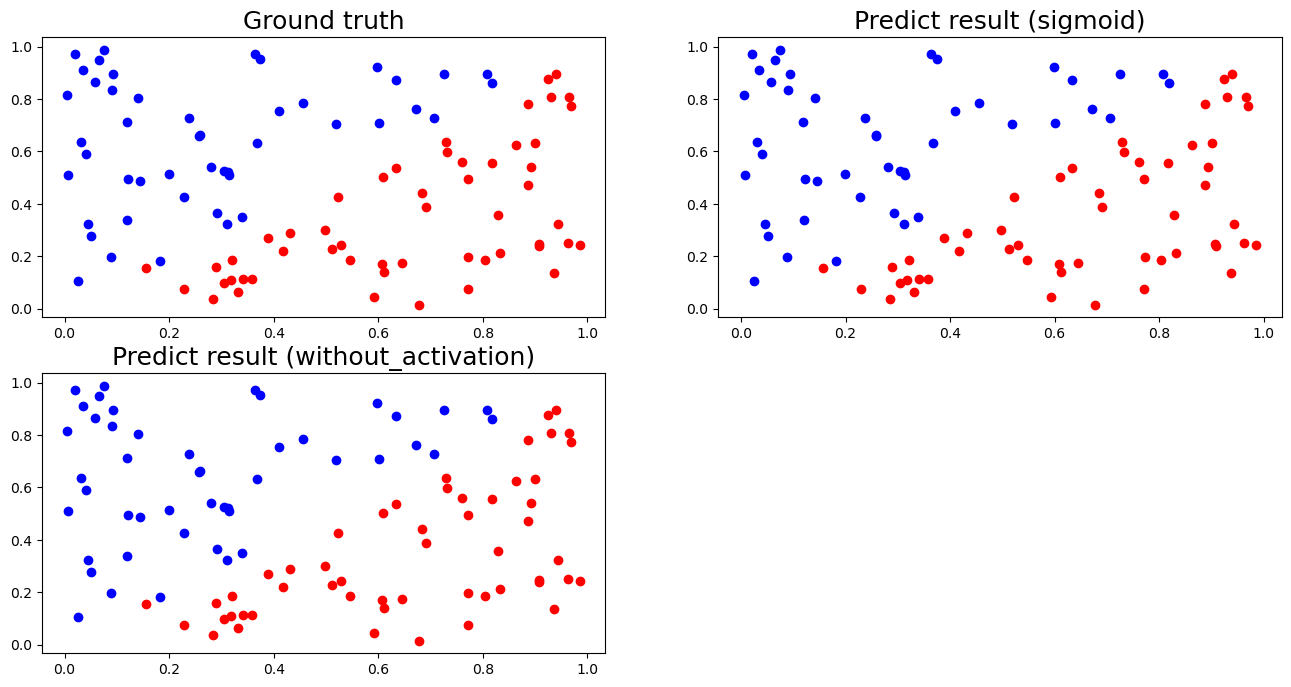

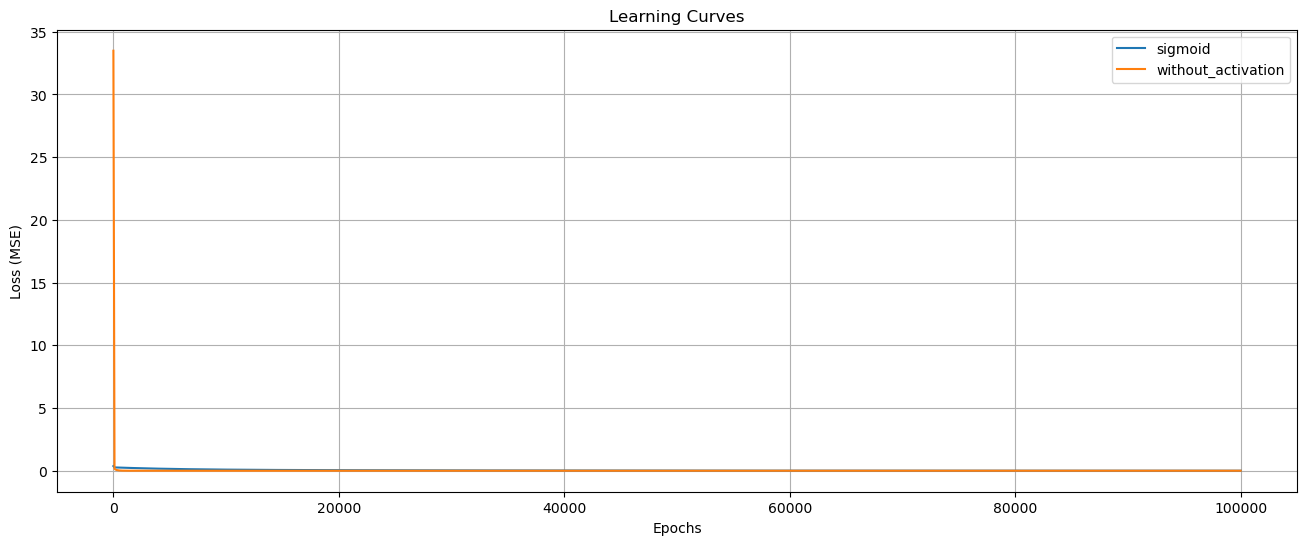

In [13]:
x,y = linear_data
models = []
predicts = []
histories = []
labels = []

for i, function in enumerate([Activation.sigmoid, Activation.without_activation]):
    # Training
    model = NeuralNetwork(x.shape[1],1,x.shape[0],activation=function)
    models.append(model)
    print(f"--------------- Training (function = {function.__name__}) ----------------")
    train_out, train_model_mse, history = model.train(x,y)  
    histories.append(history)
    labels.append(f"{function.__name__}")  

    # Testing
    print(f"--------------- Testing (function = {function.__name__}) -----------------")
    y_pred_prob = model.predict_prob(x)
    train_loss = NeuralNetwork.loss(y, y_pred_prob)
    predict = np.where(y_pred_prob > 0.5, 1, 0)
    print(f"loss: {train_loss} accuracy: {sum(1 for i, j in zip(y, predict) if i == j) / len(y)}\n")
    predicts.append(predict)
    
show_result(x, y, predicts, labels)
learning_curve(histories, labels)

#### XOR Data

--------------- Training (function = sigmoid) ----------------
epoch 0 loss : 0.3331684039256011
epoch 5000 loss : 0.14448072672473233
epoch 10000 loss : 0.08708821377441665
epoch 15000 loss : 0.05846790360678714
epoch 20000 loss : 0.04250290893753193
epoch 25000 loss : 0.03265735915885192
epoch 30000 loss : 0.026100717876688367
epoch 35000 loss : 0.021476057078526938
epoch 40000 loss : 0.0180696114393323
epoch 45000 loss : 0.015475293679779102
epoch 50000 loss : 0.013446540764190102
epoch 55000 loss : 0.011825482546079765
epoch 60000 loss : 0.010506615900916437
epoch 65000 loss : 0.009416961709807246
epoch 70000 loss : 0.00850459955112987
epoch 75000 loss : 0.007731714698652005
epoch 80000 loss : 0.007070207817015208
epoch 85000 loss : 0.006498829241651059
epoch 90000 loss : 0.006001256438253078
epoch 95000 loss : 0.005564774154383067
epoch 100000 loss : 0.005179350168118591
--------------- Testing (function = sigmoid) -----------------
loss: 0.005179277627667562 accuracy: 1.0

------

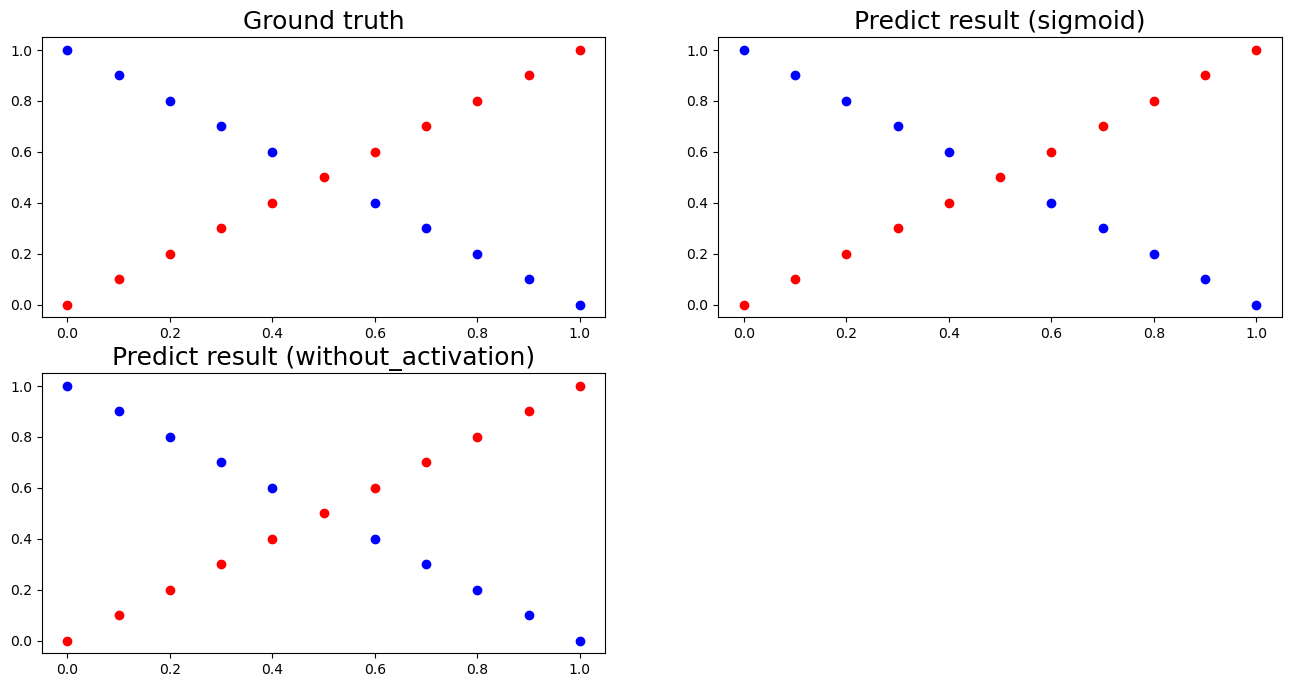

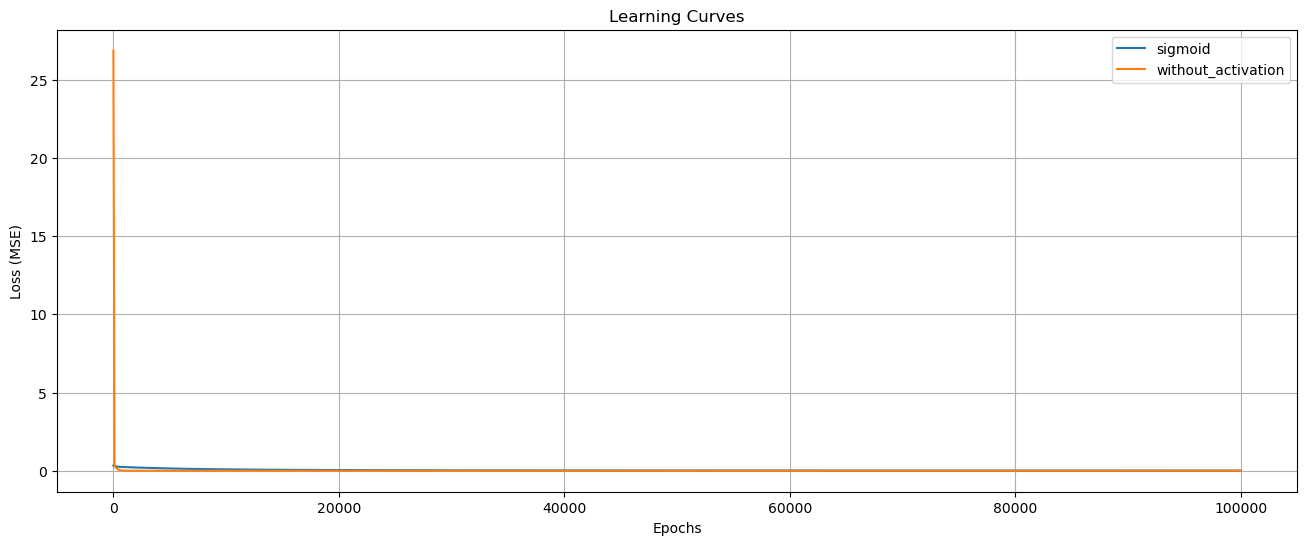

In [14]:
x,y = xor_data
models = []
histories = []
predicts = []
labels = []

for i, function in enumerate([Activation.sigmoid, Activation.without_activation]):
    # Training
    model = NeuralNetwork(x.shape[1],1,x.shape[0],activation=function)
    models.append(model)
    print(f"--------------- Training (function = {function.__name__}) ----------------")
    train_out, train_model_mse, history = model.train(x,y)  
    histories.append(history)
    labels.append(f"{function.__name__}")  

    # Testing
    print(f"--------------- Testing (function = {function.__name__}) -----------------")
    y_pred_prob = model.predict_prob(x)
    train_loss = NeuralNetwork.loss(y, y_pred_prob)
    predict = np.where(y_pred_prob > 0.5, 1, 0)
    print(f"loss: {train_loss} accuracy: {sum(1 for i, j in zip(y, predict) if i == j) / len(y)}\n")
    predicts.append(predict)
    
show_result(x, y, predicts, labels)
learning_curve(histories, labels)

## Extra

### A. Implement different optimizers

#### AdaGrad Optimizer

**Linear Data**

--------------- Training (optimizer = None) ----------------
epoch 0 loss : 0.41555388376944363
epoch 5000 loss : 0.35039922758271375
epoch 10000 loss : 0.28686493438789673
epoch 15000 loss : 0.2596783308337284
epoch 20000 loss : 0.25204174376309046
epoch 25000 loss : 0.24928837709070492
epoch 30000 loss : 0.247540973399747
epoch 35000 loss : 0.24599885878327196
epoch 40000 loss : 0.2445033879927718
epoch 45000 loss : 0.24302339065251385
epoch 50000 loss : 0.24155279376788205
epoch 55000 loss : 0.240090435233682
epoch 60000 loss : 0.23863610484187153
epoch 65000 loss : 0.23718977389412668
epoch 70000 loss : 0.23575144685665997


epoch 75000 loss : 0.23432113319346448
epoch 80000 loss : 0.23289884213398848
epoch 85000 loss : 0.23148458174502629
epoch 90000 loss : 0.23007835878931274
epoch 95000 loss : 0.22868017872079582
epoch 100000 loss : 0.22729004570096328
--------------- Testing (optimizer = None) -----------------
loss: 0.2272897684794387 accuracy: 0.59

--------------- Training (optimizer = AdaGrad) ----------------
epoch 0 loss : 0.4092253690624459
epoch 5000 loss : 0.32240766847425706
epoch 10000 loss : 0.2827789239123336
epoch 15000 loss : 0.25401565254958564
epoch 20000 loss : 0.23152488414230468
epoch 25000 loss : 0.21333789271456077
epoch 30000 loss : 0.19830750274495795
epoch 35000 loss : 0.18567907669418038
epoch 40000 loss : 0.1749337153191649
epoch 45000 loss : 0.16569544784976578
epoch 50000 loss : 0.15767743276034454
epoch 55000 loss : 0.15065376210703443
epoch 60000 loss : 0.14444385255343345
epoch 65000 loss : 0.13890234378847618
epoch 70000 loss : 0.13391171385508638
epoch 75000 loss : 0.1

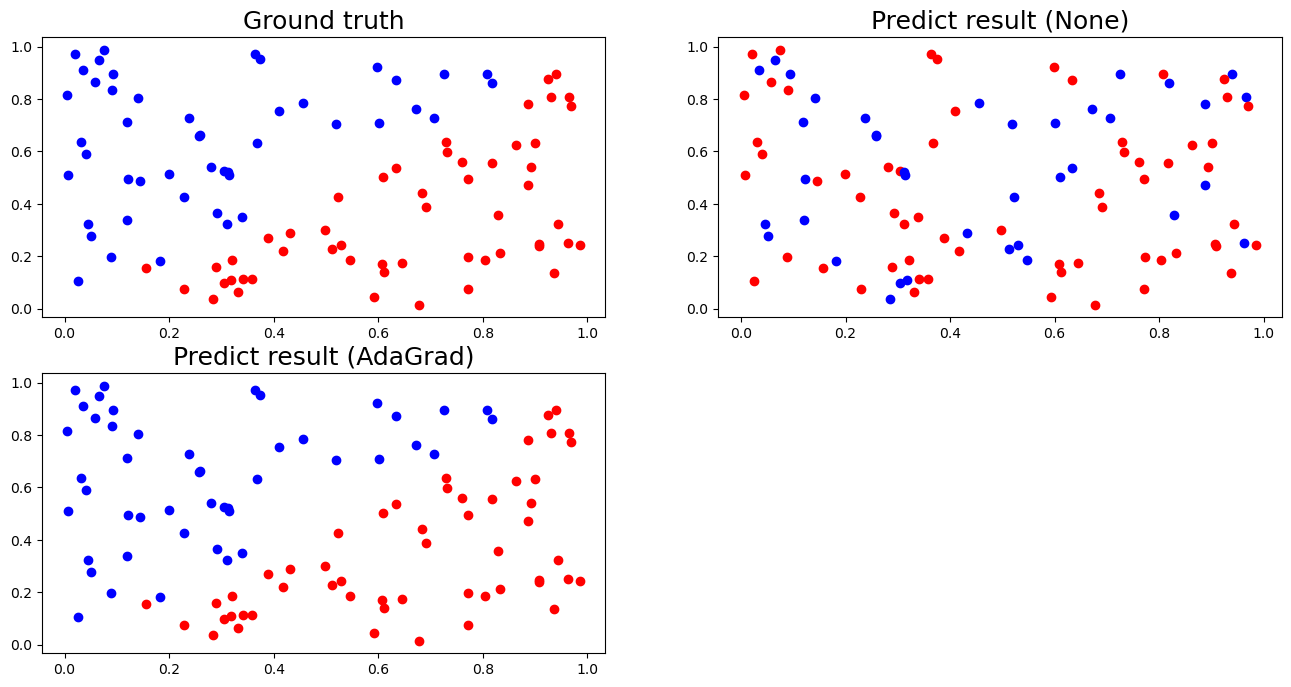

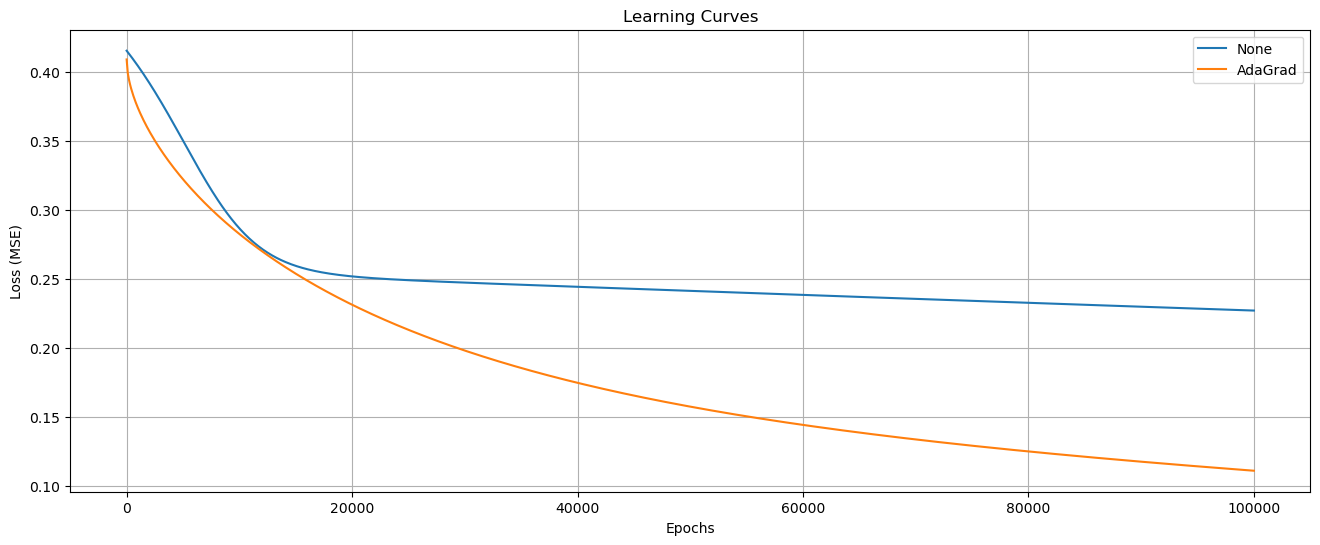

In [15]:
x,y = linear_data
models = []
histories = []
predicts = []
labels = []

for i, optimizer in enumerate([None, "AdaGrad"]):
    # Training
    model = NeuralNetwork(x.shape[1],1,x.shape[0],optimizer=optimizer,learning_rate=0.00001)
    models.append(model)
    print(f"--------------- Training (optimizer = {optimizer}) ----------------")
    train_out, train_model_mse, history = model.train(x,y)  
    histories.append(history)
    labels.append(f"{optimizer}")  

    # Testing
    print(f"--------------- Testing (optimizer = {optimizer}) -----------------")
    y_pred_prob = model.predict_prob(x)
    train_loss = NeuralNetwork.loss(y, y_pred_prob)
    predict = np.where(y_pred_prob > 0.5, 1, 0)
    print(f"loss: {train_loss} accuracy: {sum(1 for i, j in zip(y, predict) if i == j) / len(y)}\n")
    predicts.append(predict)
    
show_result(x, y, predicts, labels)
learning_curve(histories, labels)

**XOR Data**

--------------- Training (optimizer = None) ----------------
epoch 0 loss : 0.34777291426929535
epoch 5000 loss : 0.3281181324708059
epoch 10000 loss : 0.30853855549039266
epoch 15000 loss : 0.2901480189907204
epoch 20000 loss : 0.27389647591234706
epoch 25000 loss : 0.26032454025836216
epoch 30000 loss : 0.2495020426412858
epoch 35000 loss : 0.24114400972402028
epoch 40000 loss : 0.2347935296559441
epoch 45000 loss : 0.22997193247973677
epoch 50000 loss : 0.22626184183841808
epoch 55000 loss : 0.22333497427140267
epoch 60000 loss : 0.22094890888934723
epoch 65000 loss : 0.21893164208126487
epoch 70000 loss : 0.21716423328594608
epoch 75000 loss : 0.21556580243729678
epoch 80000 loss : 0.21408195593000492
epoch 85000 loss : 0.21267638386809673
epoch 90000 loss : 0.211324971964455
epoch 95000 loss : 0.2100117639316098
epoch 100000 loss : 0.20872623037041965
--------------- Testing (optimizer = None) -----------------
loss: 0.20872597552320157 accuracy: 0.7142857142857143

--------------

epoch 45000 loss : 0.186638041409558
epoch 50000 loss : 0.17512127808576466
epoch 55000 loss : 0.16509670705163165
epoch 60000 loss : 0.15631029307497732
epoch 65000 loss : 0.14855677811850918
epoch 70000 loss : 0.1416695417717034
epoch 75000 loss : 0.13551263133809707
epoch 80000 loss : 0.1299745520409557
epoch 85000 loss : 0.12496341816674163
epoch 90000 loss : 0.12040314465475509
epoch 95000 loss : 0.11623043772411228
epoch 100000 loss : 0.11239240507125407
--------------- Testing (optimizer = AdaGrad) -----------------
loss: 0.11239166785295776 accuracy: 1.0



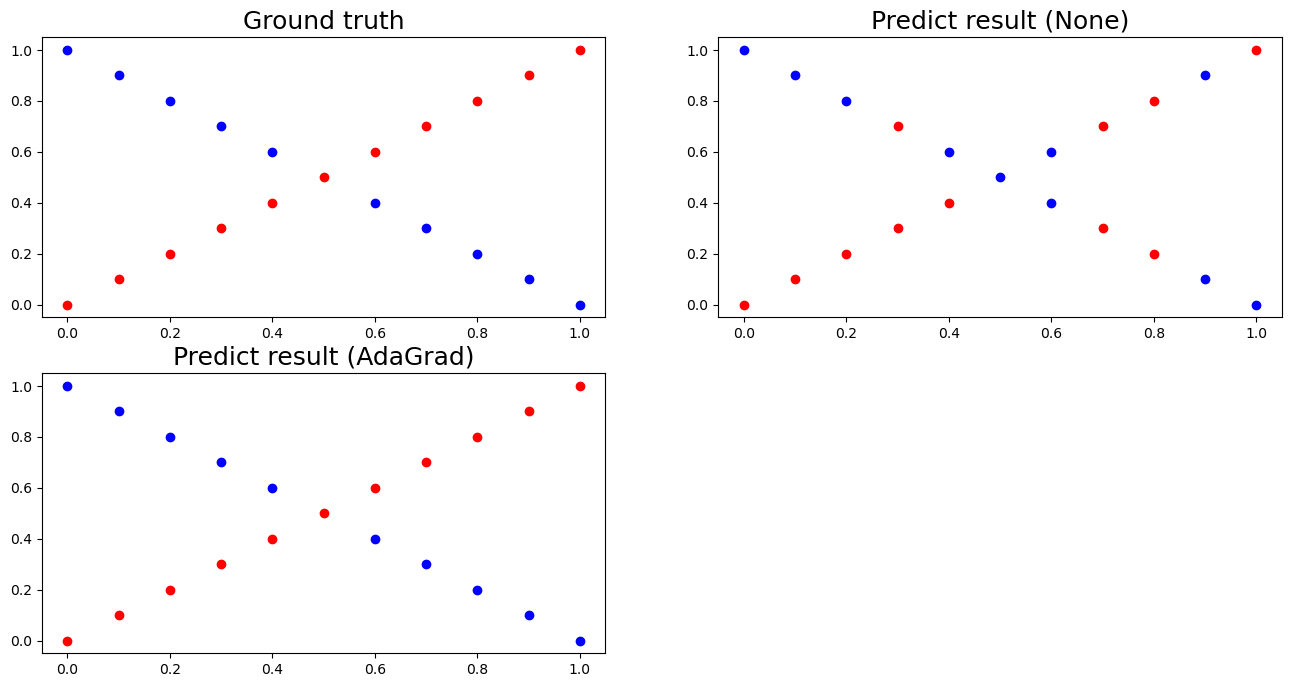

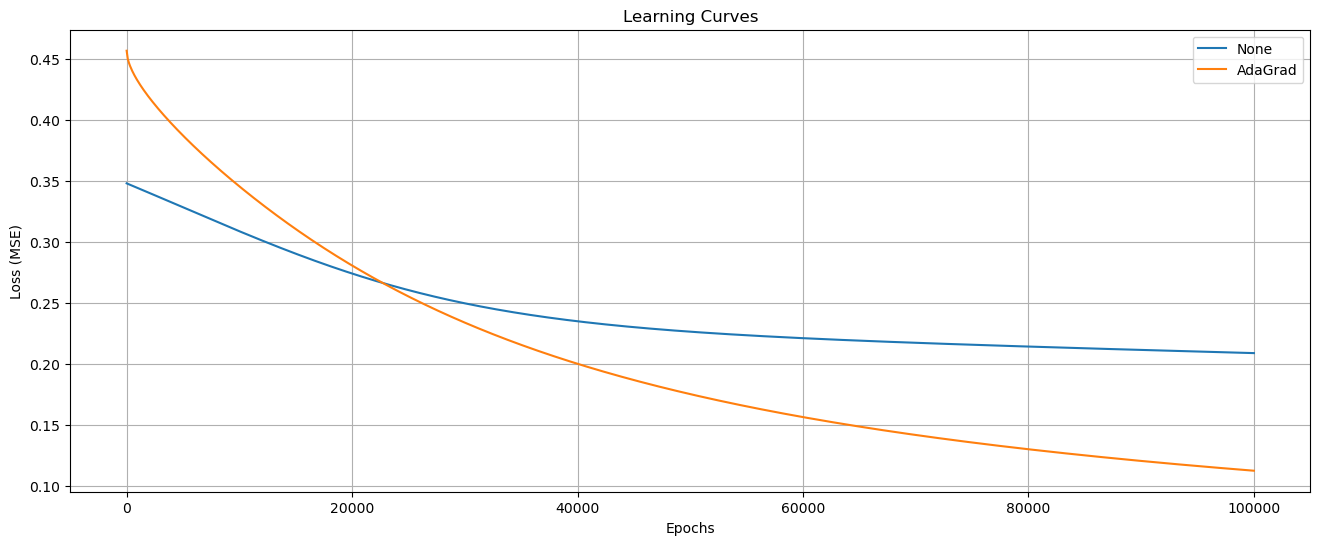

In [16]:
x,y = xor_data
models = []
histories = []
predicts = []
labels = []

for i, optimizer in enumerate([None, "AdaGrad"]):
    # Training
    model = NeuralNetwork(x.shape[1],1,x.shape[0],optimizer=optimizer,learning_rate=0.00001)
    models.append(model)
    print(f"--------------- Training (optimizer = {optimizer}) ----------------")
    train_out, train_model_mse, history = model.train(x,y)  
    histories.append(history)
    labels.append(f"{optimizer}")  

    # Testing
    print(f"--------------- Testing (optimizer = {optimizer}) -----------------")
    y_pred_prob = model.predict_prob(x)
    train_loss = NeuralNetwork.loss(y, y_pred_prob)
    predict = np.where(y_pred_prob > 0.5, 1, 0)
    print(f"loss: {train_loss} accuracy: {sum(1 for i, j in zip(y, predict) if i == j) / len(y)}\n")
    predicts.append(predict)
    
show_result(x, y, predicts, labels)
learning_curve(histories, labels)

### B. Implement different activation functions

#### Linear Data

--------------- Training (function = sigmoid) ----------------
epoch 0 loss : 0.39020656297335987
epoch 5000 loss : 0.2394628390593426
epoch 10000 loss : 0.22541522198639832
epoch 15000 loss : 0.21216890576735942
epoch 20000 loss : 0.19971948784073867
epoch 25000 loss : 0.18805230507847429
epoch 30000 loss : 0.17714430183176655
epoch 35000 loss : 0.16696584586797386
epoch 40000 loss : 0.1574824346122442
epoch 45000 loss : 0.14865624156523766
epoch 50000 loss : 0.1404474670552889
epoch 55000 loss : 0.13281547489791154
epoch 60000 loss : 0.12571971299312013
epoch 65000 loss : 0.11912042916315788
epoch 70000 loss : 0.11297920279828194
epoch 75000 loss : 0.10725931826189804
epoch 80000 loss : 0.10192600815769984
epoch 85000 loss : 0.09694659431469459
epoch 90000 loss : 0.09229055248674771
epoch 95000 loss : 0.08792952389359834
epoch 100000 loss : 0.08383729321357807
--------------- Testing (function = sigmoid) -----------------
loss: 0.08383650001007091 accuracy: 1.0

--------------- Train

epoch 25000 loss : 0.024658453771608205
epoch 30000 loss : 0.016911582291655597
epoch 35000 loss : 0.012281545333867359
epoch 40000 loss : 0.009314767466719116
epoch 45000 loss : 0.0072978861237842415
epoch 50000 loss : 0.00586251722747731
epoch 55000 loss : 0.004805004088288648
epoch 60000 loss : 0.004004640996730771
epoch 65000 loss : 0.003385491812629779
epoch 70000 loss : 0.002897562667329363
epoch 75000 loss : 0.002506795490627492
epoch 80000 loss : 0.0021893581915447265
epoch 85000 loss : 0.0019282007099132668
epoch 90000 loss : 0.001710890052612773
epoch 95000 loss : 0.0015282055788978374
epoch 100000 loss : 0.001373204173588893
--------------- Testing (function = tanh) -----------------
loss: 0.001373175566196494 accuracy: 1.0



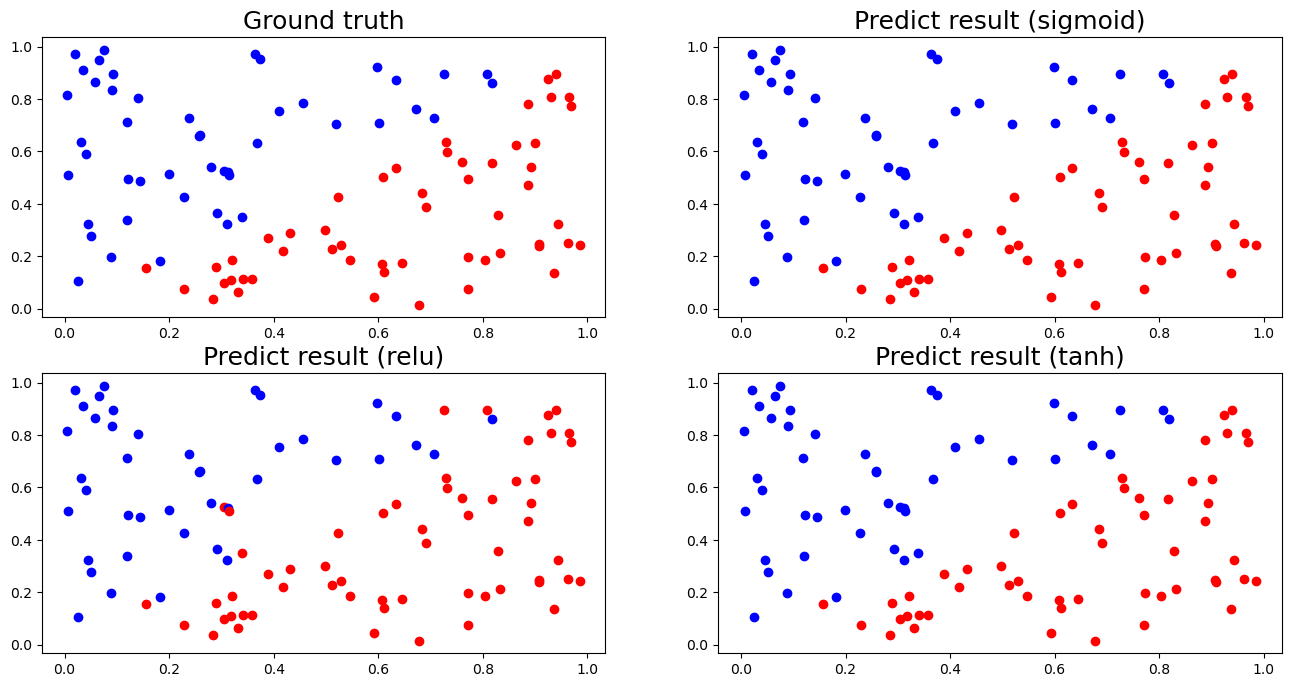

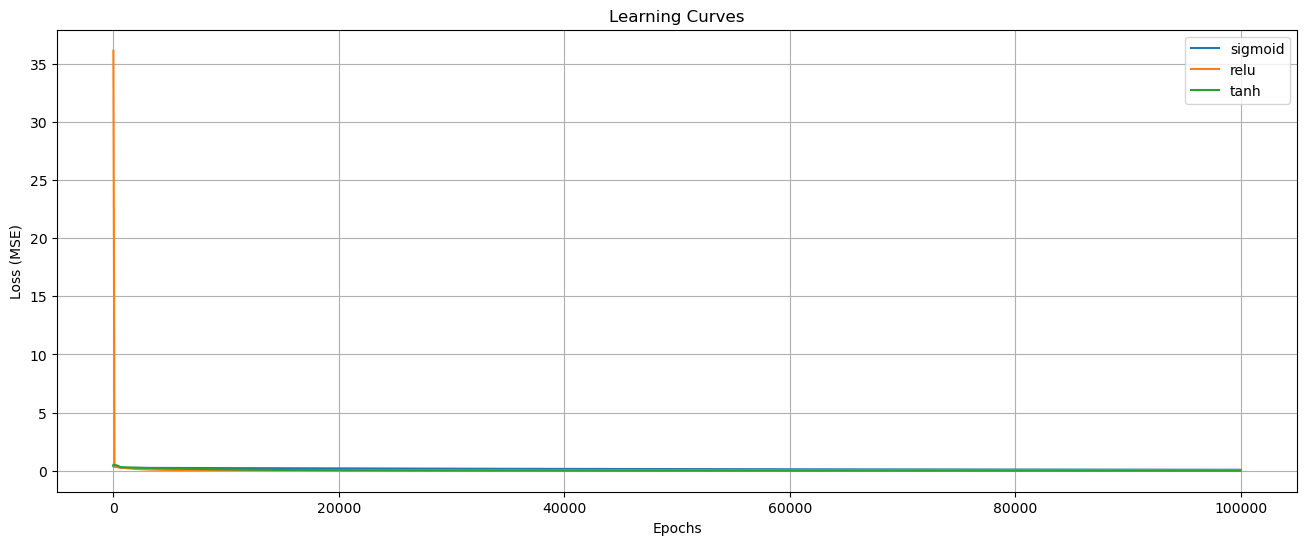

In [17]:
x,y = linear_data
models = []
histories = []
predicts = []
labels = []

for i, function in enumerate([Activation.sigmoid, Activation.relu, Activation.tanh]):
    # Training
    model = NeuralNetwork(x.shape[1],1,x.shape[0],activation=function, learning_rate=0.0001)
    models.append(model)
    print(f"--------------- Training (function = {function.__name__}) ----------------")
    train_out, train_model_mse, history = model.train(x,y)  
    histories.append(history)
    labels.append(f"{function.__name__}")  

    # Testing
    print(f"--------------- Testing (function = {function.__name__}) -----------------")
    y_pred_prob = model.predict_prob(x)
    train_loss = NeuralNetwork.loss(y, y_pred_prob)
    predict = np.where(y_pred_prob > 0.5, 1, 0)
    print(f"loss: {train_loss} accuracy: {sum(1 for i, j in zip(y, predict) if i == j) / len(y)}\n")
    predicts.append(predict)
    
show_result(x, y, predicts, labels)
learning_curve(histories, labels)

#### XOR Data

--------------- Training (function = sigmoid) ----------------
epoch 0 loss : 0.4079734300007169
epoch 5000 loss : 0.289884091814799
epoch 10000 loss : 0.2467038202618404
epoch 15000 loss : 0.2306677364538407
epoch 20000 loss : 0.21695304190968906
epoch 25000 loss : 0.204135354019465
epoch 30000 loss : 0.19214427374501403
epoch 35000 loss : 0.18095370137833577
epoch 40000 loss : 0.1705320409657047
epoch 45000 loss : 0.1608425080130887
epoch 50000 loss : 0.15184485504165912
epoch 55000 loss : 0.14349689440252078
epoch 60000 loss : 0.13575576165030498
epoch 65000 loss : 0.12857892150358896
epoch 70000 loss : 0.12192493450515259
epoch 75000 loss : 0.11575401223934272


epoch 80000 loss : 0.11002839349463127
epoch 85000 loss : 0.1047125743520603
epoch 90000 loss : 0.09977342316360224
epoch 95000 loss : 0.09518020788330801
epoch 100000 loss : 0.09090455907461142
--------------- Testing (function = sigmoid) -----------------
loss: 0.09090373393109426 accuracy: 1.0

--------------- Training (function = relu) ----------------
epoch 0 loss : 30.39944768469969
epoch 5000 loss : 0.17597812227361753
epoch 10000 loss : 0.10927522093447022
epoch 15000 loss : 0.09723739537667984
epoch 20000 loss : 0.09553413390322632
epoch 25000 loss : 0.09528342371317515
epoch 30000 loss : 0.0952451038883674
epoch 35000 loss : 0.09523919058211153
epoch 40000 loss : 0.09523826821210235
epoch 45000 loss : 0.09523812280786824
epoch 50000 loss : 0.09523809966784214
epoch 55000 loss : 0.09523809595476776
epoch 60000 loss : 0.0952380953547089
epoch 65000 loss : 0.09523809525712627
epoch 70000 loss : 0.09523809524120687
epoch 75000 loss : 0.09523809523860484
epoch 80000 loss : 0.09523

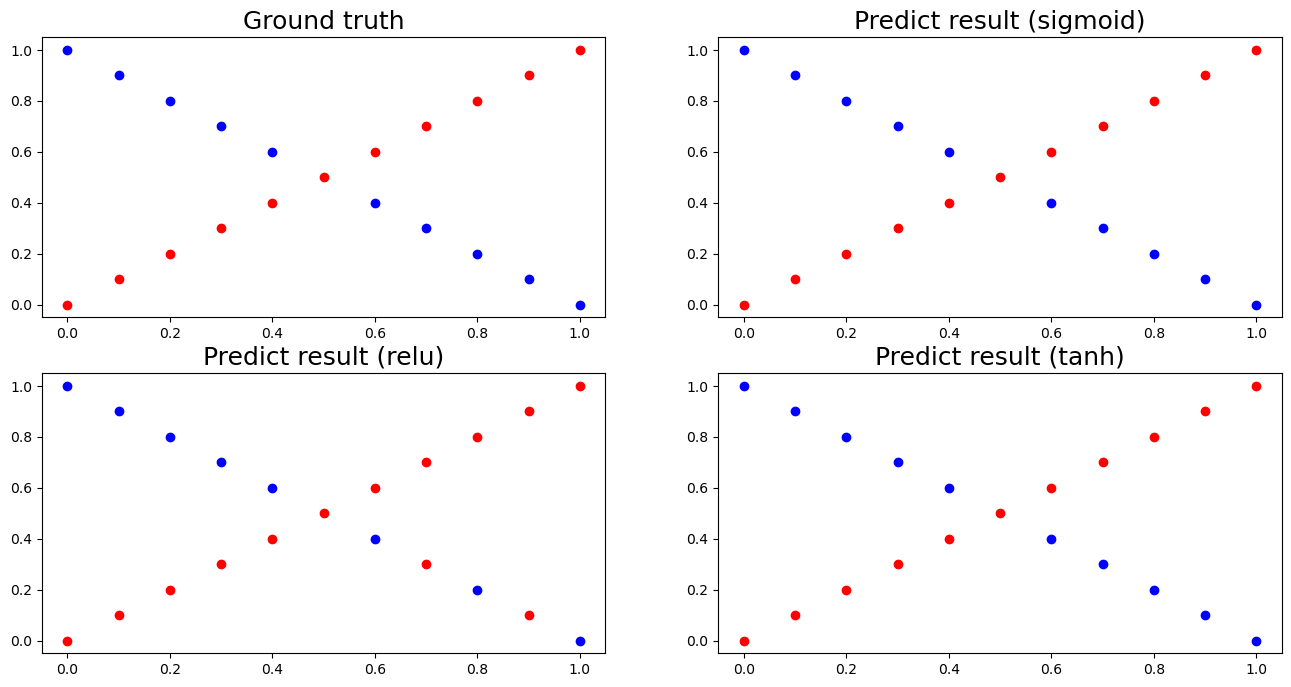

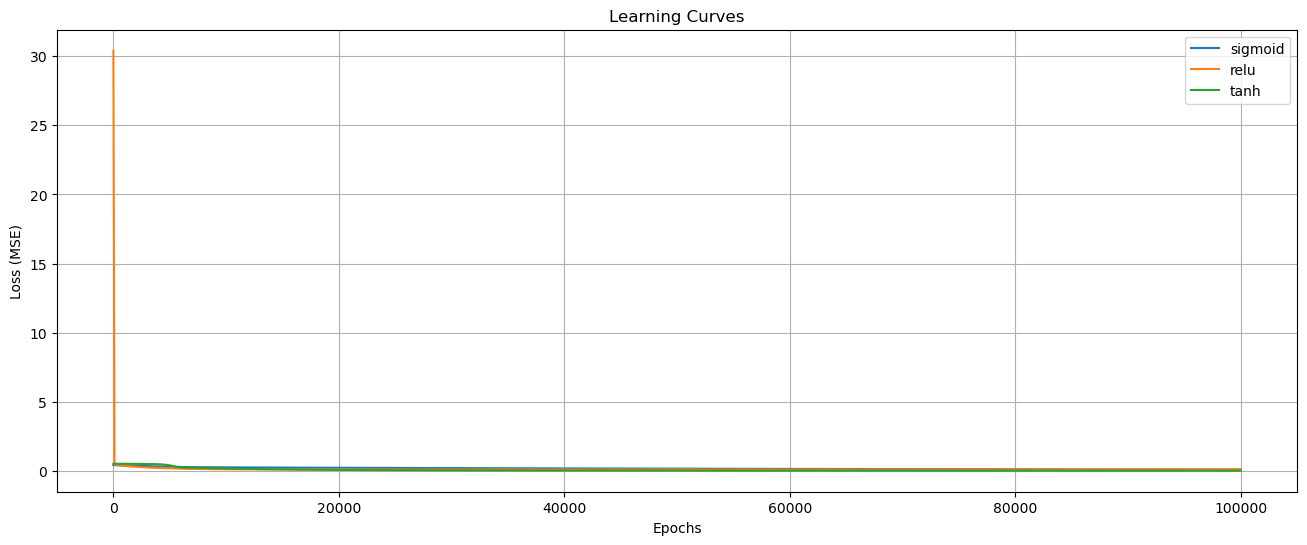

In [18]:
x,y = xor_data
models = []
histories = []
predicts = []
labels = []

for i, function in enumerate([Activation.sigmoid, Activation.relu, Activation.tanh]):
    # Training
    model = NeuralNetwork(x.shape[1],1,x.shape[0],activation=function,learning_rate=0.0001)
    models.append(model)
    print(f"--------------- Training (function = {function.__name__}) ----------------")
    train_out, train_model_mse, history = model.train(x,y)  
    histories.append(history)
    labels.append(f"{function.__name__}")  

    # Testing
    print(f"--------------- Testing (function = {function.__name__}) -----------------")
    y_pred_prob = model.predict_prob(x)
    train_loss = NeuralNetwork.loss(y, y_pred_prob)
    predict = np.where(y_pred_prob > 0.5, 1, 0)
    print(f"loss: {train_loss} accuracy: {sum(1 for i, j in zip(y, predict) if i == j) / len(y)}\n")
    predicts.append(predict)
    
show_result(x, y, predicts, labels)
learning_curve(histories, labels)

### C. Implement convolutional layers